In this example, we will show how to use ```simple_bind``` API. 

Note it is a low level API, by using low level API we are able to touch more details about MXNet

In [2]:
import mxnet as mx
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

We will use a very simple 1 hidden layer BatchNorm fully connected MNIST network to demo how to use low level API.
The network looks like:

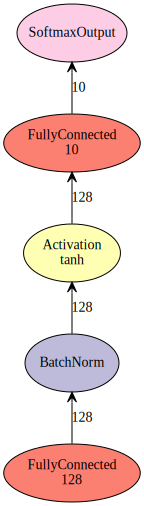

In [3]:
# we can use mx.sym in short of mx.symbol
data = mx.sym.Variable("data")
fc1 = mx.sym.FullyConnected(data=data, num_hidden=128, name="fc1")
bn1 = mx.sym.BatchNorm(data=fc1, name="bn1")
act1 = mx.sym.Activation(data=bn1, name="act1", act_type="tanh")
fc2 = mx.sym.FullyConnected(data=act1, name="fc2", num_hidden=10)
softmax = mx.sym.Softmax(data=fc2, name="softmax")
# visualize the network
batch_size = 100
data_shape = (batch_size, 784)
mx.viz.plot_network(softmax, shape={"data":data_shape}, node_attrs={"shape":'oval',"fixedsize":'false'})

We can use ```simple_bind``` api to generate executor from symbol.

In [4]:
# context different to ```mx.model```, 
# In mx.model, we wrapped parameter server, but for a single executor, the context is only able to be ONE device
# run on cpu
ctx = mx.cpu()
# run on gpu
# ctx = mx.gpu()
# run on third gpu
# ctx = mx.gpu(2)
executor = softmax.simple_bind(ctx=ctx, data=data_shape, grad_req='write')
# The default ctx is CPU, data's shape is required and ```simple_bind``` will try to infer all other required 
# For MLP, the ```grad_req``` is write to, and for RNN it is different

After generating executor, we get get data from executor

In [5]:
# get argument arrays
arg_arrays = executor.arg_arrays
# get grad arrays
grad_arrays = executor.grad_arrays
# get aux_states arrays. Note: currently only BatchNorm symbol has auxiliary states, which is moving_mean and moving_var
aux_arrays = executor.aux_arrays
# get outputs from executor
output_arrays = executor.outputs

The sequence of arrays is in same sequence of symbol arguments

In [6]:
args = dict(zip(softmax.list_arguments(), arg_arrays))
grads = dict(zip(softmax.list_arguments(), grad_arrays))
outputs = dict(zip(softmax.list_outputs(), output_arrays))
aux_states = dict(zip(softmax.list_auxiliary_states(), aux_arrays))
# we can print the args we have
print("args: ", args)
print("-" * 20)
print("grads: ", grads)
print("-" * 20)
print("aux_states: ", aux_states)
print("-" * 20)
print("outputs: ", outputs)

('args: ', {'bn1_beta': <mxnet.ndarray.NDArray object at 0x7f4da2aa92d0>, 'fc2_weight': <mxnet.ndarray.NDArray object at 0x7f4da2aa9310>, 'fc1_weight': <mxnet.ndarray.NDArray object at 0x7f4d98d4e690>, 'softmax_label': <mxnet.ndarray.NDArray object at 0x7f4da2aa9550>, 'bn1_gamma': <mxnet.ndarray.NDArray object at 0x7f4da2aa9250>, 'fc2_bias': <mxnet.ndarray.NDArray object at 0x7f4da2aa9290>, 'data': <mxnet.ndarray.NDArray object at 0x7f4d98d4eb50>, 'fc1_bias': <mxnet.ndarray.NDArray object at 0x7f4da2a90150>})
--------------------
('grads: ', {'bn1_beta': <mxnet.ndarray.NDArray object at 0x7f4da2aa93d0>, 'fc2_weight': <mxnet.ndarray.NDArray object at 0x7f4da2aa9510>, 'fc1_weight': <mxnet.ndarray.NDArray object at 0x7f4da2aa9590>, 'softmax_label': None, 'bn1_gamma': <mxnet.ndarray.NDArray object at 0x7f4da2aa9390>, 'fc2_bias': <mxnet.ndarray.NDArray object at 0x7f4da2aa94d0>, 'data': None, 'fc1_bias': <mxnet.ndarray.NDArray object at 0x7f4da2aa9350>})
--------------------
('aux_states: '

The next step is intilize weight. We can set weight directly by using ```mx.random``` or numpy ndarray

In [7]:
# helper function
def Init(key, arr):
    if "weight" in key:
        arr[:] = mx.random.uniform(-0.07, 0.07, arr.shape)
        # or
        # arr[:] = np.random.uniform(-0.07, 0.07, arr.shape)
    elif "gamma" in key:
        # for batch norm slope
        arr[:] = 1.0
    elif "bias" in key:
        arr[:] = 0
    elif "beta" in key:
        # for batch norm bias
        arr[:] = 0

# Init args
for key, arr in args.items():
    Init(key, arr)

Then we can customize our update rule. Here for demo purpose, we make a simple update rule to show mxnet feature

In [8]:
def SGD(key, weight, grad, lr=0.1, grad_norm=batch_size):
    # key is key for weight, we can customize update rule
    # weight is weight array
    # grad is grad array
    # lr is learning rate
    # grad_norm is scalar to norm gradient, usually it is batch_size
    norm = 1.0 / grad_norm
    # here we can bias' learning rate 2 times larger than weight
    if "weight" in key or "gamma" in key:
        weight[:] -= lr * (grad * norm)
    elif "bias" in key or "beta" in key:
        weight[:] -= 2.0 * lr * (grad * norm)
    else:
        pass
    
    

Then we will make a data iterator. We can either use build in iterator to load from binary file or build a numpy iterator.

For special case, you are free to write your own iterator in python

In [9]:
# We use utils function in sklearn to get MNIST dataset in pickle
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
mnist = fetch_mldata('MNIST original', data_home="./data")
# shuffle data
X, y = shuffle(mnist.data, mnist.target)
# split dataset
train_data = X[:50000, :].astype('float32')
train_label = y[:50000]
val_data = X[50000: 60000, :].astype('float32')
val_label = y[50000:60000]
# Normalize data
train_data[:] /= 256.0
val_data[:] /= 256.0
# Build iterator
train_iter = mx.io.NDArrayIter(data=train_data, label=train_label, batch_size=batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(data=val_data, label=val_label, batch_size=batch_size)

Also, we need to define a helper function to calculate accuracy of current training

In [10]:
def Accuracy(label, pred_prob):
    pred = np.argmax(pred_prob, axis=1)
    return np.sum(label == pred) * 1.0 / label.shape[0]

Then we can train the network by using executor

In [13]:
num_round = 3
keys = softmax.list_arguments()
# we use extra ndarray to save output of net
pred_prob = mx.nd.zeros(executor.outputs[0].shape)
for i in range(num_round):
    train_iter.reset()
    val_iter.reset()
    train_acc = 0.
    val_acc = 0.
    nbatch = 0.
    # train
    for dbatch in train_iter:
        data = dbatch.data[0]
        label = dbatch.label[0]
        # copy data into args
        args["data"][:] = data # or we can ```data.copyto(args["data"])```
        args["softmax_label"][:] = label
        executor.forward(is_train=True)
        pred_prob[:] = executor.outputs[0]
        executor.backward()
        for key in keys:
            SGD(key, args[key], grads[key])
        train_acc += Accuracy(label.asnumpy(), pred_prob.asnumpy())
        nbatch += 1.
    logging.info("Finish training iteration %d" % i)
    train_acc /= nbatch
    nbatch = 0.
    # eval
    for dbatch in val_iter:
        data = dbatch.data[0]
        label = dbatch.label[0]
        args["data"][:] = data
        executor.forward(is_train=False)
        pred_prob[:] = executor.outputs[0]
        val_acc += Accuracy(label.asnumpy(), pred_prob.asnumpy())
        nbatch += 1.
    val_acc /= nbatch
    logging.info("Train Acc: %.4f" % train_acc)
    logging.info("Val Acc: %.4f" % val_acc)
        
        

INFO:root:Finish training iteration 0
INFO:root:Train Acc: 0.9506
INFO:root:Val Acc: 0.9480
INFO:root:Finish training iteration 1
INFO:root:Train Acc: 0.9579
INFO:root:Val Acc: 0.9521
INFO:root:Finish training iteration 2
INFO:root:Train Acc: 0.9639
INFO:root:Val Acc: 0.9551


This is simple example gives a demo on how to directly use symbolic API to build a neural net from scratch.